## 之前的实验效果都没啥提升，我太难过了，再尝试加入新的特征---我可以多模仿陈姗姗论文里写的
- 加入句法分析树深度特征：句子深度最大值/平均值/平均从句数量/平均从句长度/句子平均动词、名词、情态动词、介词、标点数目/句法的复杂程度 比如说多少个主谓关系/动宾关系等等
- 加入语法检错特征 （我觉得这个特征很重要呀！有了这个特征估计评分会准确很多）：以 3-gram 词汇组合为例，“like going to”在维基百科中的词频为 425，而“like  go  to”的词频仅仅为 25，可以看出词频较小的词汇组合可能与文本中语法的错误相关；设定不同的窗口大小，得到不同窗口大小下的词汇组合，然后看这个词汇组合在维基百科数据下的文本出现频率，再把作文的这些频率加和取平均吧，这样就可以得到整个作文的词汇正确频率大小了
- 长度大于4,6,8,10,12的词汇个数  --复现陈姗姗论文
- 长度大于5/10/15/25的句子 --复现陈姗姗论文
- 文本情感特征


In [164]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
#import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')

## 读取数据

In [2]:
essay_csv = "essay_test.csv"

dataframe = pd.read_csv(essay_csv, encoding = 'latin-1')
#copy一份数据
data = dataframe[['id','essay','score']].copy()

In [3]:
data.head()

id                                              essay  score
0  10001  Dear Jerry. I've heard about that you will giv...   19.5
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0

## 数据预处理--替换缩写

In [4]:
# 首先对句子做一个清洗，需要把缩写转换为原来的单词，如把I'm 转换成I am
def covert_abb2words(essay):
    #essay = essay.lower()
    essay = essay.replace("I'm","I am").replace("'ve"," have").replace("'ll"," will").replace("n't"," not")
    return essay

In [5]:
data["corrected"] = data.apply(lambda x : covert_abb2words(x["essay"]),axis=1)

In [6]:
data.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  
0  Dear Jerry. I have heard about that you will g...  
1  Dear Jerry I am glad that you will respresent ...  
2  Dear Jerry, I am very happy to hear that you w...  
3  Dear Je I am so happy to hear that you will ha...  
4  Dear Jerry, I am so glad to hear that you will...

## 浅层信息提取

In [7]:
example = '''
Dear Jerry I'm gale that you can get an English leature for high school Gread one I know you have many diffict need to solve. I'll try my best to help you. I belive that you can do well. you also should try your best to do. You say that have many don't know thing. These thing are so easy. You don't worry about more this. Firstly. you should read the leature again and again. to know about comply. This is a bab. Sencondly. you should have active bodly baod to let your leature become interesting and active and acttilt. I belive you can do well Fillaly you need to say that Thanks you come there listen to my leature. then come back friendly. These thing I belive that you can do well. look farward to you Yours, Li Hua

'''

### 词法特征

In [8]:
# 把每个句子都拆成单词列表
def tokenize(essay):
    # 去掉句子前后空格
    stripped_essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay) # 分句
    #print(raw_sentences)
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    return tokenized_sentences

In [9]:
# 返回总的单词列表
def sentence_to_wordlist(raw_sentence):
    #句子清洗
    # re的用法：replacedStr = re.sub("\d+", "222", inputStr)
    clean_sentence = re.sub("[^a-zA-Z0-9]", " ", raw_sentence)# 这里主要是去除除了a-zA-Z0-9之外的字符
    #nltk 分词
    tokens = nltk.word_tokenize(clean_sentence)
    #返回分词的结果
    return tokens

In [16]:
## 作文长度 1
def essay_len(raw_sentence):
    #句子清洗
    # re的用法：replacedStr = re.sub("\d+", "222", inputStr)
    clean_sentence = re.sub("[^a-zA-Z0-9]", " ", raw_sentence)# 这里主要是去除除了a-zA-Z0-9之外的字符
    #nltk 分词
    tokens = nltk.word_tokenize(clean_sentence)
    #返回分词的结果
    return len(tokens)

In [64]:
essay_len(example)

144

In [24]:
## 去停用词，去重后的词表大小 2
def richness(essay):
    clean_essay = re.sub("[^a-zA-Z0-9]", " ", essay)
    tokens = nltk.word_tokenize(clean_essay)
    words = stopwords.words('english')
    filtered_words = [word for word in tokens if word not in words]
    return len(set(filtered_words))

In [272]:
richness(example)

52

In [273]:
## 词表大小占作文长度的比例 3
def rich_divide_total(essay):
    p = richness(essay)/essay_len(essay)
    return round(p,8)

In [274]:
rich_divide_total(example)

0.36111111

In [38]:
## 平均词汇长度 4
# 平均词数
def avg_word_len(essay):
    # 清洗文章
    clean_essay = re.sub(r'\W', ' ', essay)
    # 分词
    words = nltk.word_tokenize(clean_essay)
    # 遍历word，然后把每一个word的单词数目相加，然后除以总的单词数目，即可得到 每个单词平均有几个字母
    p = sum(len(word) for word in words) / len(words)
    return round(p,8)

In [39]:
avg_word_len(example)

3.89583333

In [83]:
# 名词 形容词 动词 介词 副词 5 6 7 8 9
def count_pos(essay):
    length = essay_len(essay)
    tokenized_sentences = tokenize(essay)

    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    pre_count = 0
    conj_count = 0

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]

            if pos_tag.startswith('N'):
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            elif pos_tag.startswith('IN'):
                pre_count +=1
            elif pos_tag.startswith('CC'):
                conj_count += 1

    return noun_count/length, adj_count/length, verb_count/length, adv_count/length,pre_count/length,conj_count/length

In [84]:
count_pos(example)

(0.14583333333333334,
 0.09722222222222222,
 0.2569444444444444,
 0.09722222222222222,
 0.04861111111111111,
 0.020833333333333332)

In [78]:
## 长度大于4,6,8,10,12的词汇个数 10 11 12 13 14
def words_len(essay):
    four_len = 0
    six_len = 0
    eight_len = 0
    ten_len = 0
    twl_len = 0
    for word in sentence_to_wordlist(essay):
        if len(word) >= 12:
            twl_len+=1
        elif len(word) >= 10:
            ten_len+=1
        elif len(word) >= 8:
            eight_len+=1
        elif len(word) >= 6:
            six_len+=1
        elif len(word) >= 4:
            four_len+=1
    
    return four_len,six_len,eight_len,ten_len,twl_len
            

In [79]:
words_len(example)

(0, 1, 2, 23, 54)

In [80]:
## 拼写错误词汇个数 15
# 这里需要定制化一下，加入li 和hua 这两个词
def count_spell_error(essay):
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    # big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()

    words_ = re.findall('[a-z]+', data.lower())


    word_dict = collections.defaultdict(lambda: 0)

    for word in words_:
        word_dict[word] += 1

    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    mispell_count = 0
    mispell_words = []

    words = clean_essay.split()

    for word in words:
        # 针对该文本的特殊词汇
        if word not in ["li","hua","jerry"]:
            # 如果essay中的词汇不在big data 这个文件下，那么就认为这个单词拼写错了
            if not word in word_dict:
                mispell_count += 1
                mispell_words.append(word)

    return mispell_count

In [81]:
# 16
def char_count(essay): 
    # 删除空格即返回文章字母总数
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    return len(clean_essay)

In [85]:
# 提取出所有的名词 形容词 动词 副词 17 
def count_lemmas(essay):
    #分句
    tokenized_sentences = tokenize(essay)
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()

    for sentence in tokenized_sentences:
        # 给句子标注词性
        tagged_tokens = nltk.pos_tag(sentence)
        for token_tuple in tagged_tokens:
            # 取第一个，即为该单词词性
            pos_tag = token_tuple[1]
            if pos_tag.startswith('N'):
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
                
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    lemma_count = len(set(lemmas))
    # print(lemma_count)
    return lemma_count

In [92]:
## 单词还原之后的词汇复杂度 18
# 获取单词的词性
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def get_lemma_richness(essay):
    tokens = sentence_to_wordlist(essay)  # 分词
    tagged_sent = pos_tag(tokens)     # 获取单词词性

    wnl = WordNetLemmatizer()
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) # 词形还原
    return len(set(lemmas_sent))

In [93]:
get_lemma_richness(example)

78

### 句法特征

In [17]:
## 句子个数 1
def sent_count(essay):
    sentences = nltk.sent_tokenize(essay)
    return len(sentences)

In [18]:
## 平均句子长度和方差 2 3
import numpy as np 
def get_avg_sents_var(essay):
    sent_len = []
    sents = tokenize(essay)
    for sent in sents:
        sent_len.append(len(sent))
    return np.mean(sent_len),np.var(sent_len)

In [19]:
get_avg_sents_var(example)

NameError: name 'example' is not defined

In [20]:
# 长度大于5,10,15,25的句子数量 4 5 6 7
def dif_len_sents(essay):
    tf = 0
    of = 0
    ten = 0
    five = 0
    sents = tokenize(essay)
    for sent in sents:
        if len(sent)>25:
            tf+=1
        elif len(sent)>15:
            of += 1
        elif len(sent)>10:
            ten += 1
        elif len(sent)>5:
            five += 1
    return tf,of,ten,five

In [21]:
dif_len_sents(example)

NameError: name 'example' is not defined

In [22]:
## 句子平均名词、动词 形容词 情态动词 介词 8 9 10 11 12
def avg_pos(essay):
    tokenized_sentences = tokenize(essay)
    sents_count = len(tokenized_sentences)
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    emo_count = 0
    pre_count = 0
    conj_count = 0

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]

            if pos_tag.startswith('N'):
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('MD'):
                emo_count += 1
            elif pos_tag.startswith('IN'):
                pre_count +=1

    avg_noun = noun_count/sents_count
    avg_verb = verb_count/sents_count
    avg_adj = adj_count/sents_count 
    avg_pre = pre_count/sents_count
    avg_emo = emo_count/sents_count
    
    return avg_noun,avg_verb,avg_adj,avg_pre,avg_emo


In [23]:
avg_pos(example)

NameError: name 'example' is not defined

In [24]:
## 句子平均标点符号 13
def avg_signal(essay):
    tokenized_sentences = tokenize(essay)
    sents_count = len(tokenized_sentences)
    signal_count = 0
    signals = ['!',',','.','?','-s','-ly','</s>','s']
    tokens = nltk.word_tokenize(essay)
    for token in tokens:
        if token in signals:
            signal_count+=1
            #print(token)
    avg_signal = signal_count/sents_count
    return avg_signal

In [12]:
avg_signal(example)

NameError: name 'example' is not defined

In [25]:
## 句子深度最大值  平均值
# SBR 子句平均个数  动词短语vp个数，名词短语nn个数 ADJP形容词短语个数 ADVP副词短语个数 14 15 16 17 18
from stanfordcorenlp import StanfordCoreNLP
from nltk.tree import Tree
from tqdm import tqdm
def get_vps(essay): 
    sbr_count = 0
    vp = 0
    np = 0
    adjp = 0
    advp = 0
    
    try:
        tokenized_sentences = tokenize(essay)
        sents_count = len(tokenized_sentences)

        nlp = StanfordCoreNLP(r'D:\files\chrome\stanford-corenlp-4.2.2\stanford-corenlp-4.2.2')


        for sent in tqdm(essay.split(".")):  
            #t = nlp.parse(sent)
            t = nlp.parse(sent)
            if "SBAR" in t:
                 sbr_count+=1
            elif "VP" in t:
                vp +=1
            elif "NP" in t:
                np+=1 
            elif "ADJP" in t:
                adjp +=1 
            elif "ADVP" in t:
                advp+=1
            print("success")
    except Exception as e:
            print(e)
            print("failed")
            pass
            
    avg_sbr = sbr_count/sents_count
    avg_vp = vp/sents_count
    avg_np = np/sents_count
    avg_adjp = adjp/sents_count
    avg_advp = advp/sents_count
    
    return avg_sbr,avg_vp,avg_np,avg_adjp,avg_advp
    #print ('Constituency Parsing:', nlp.parse(sent))#语法树
    
    #print("-----------------------")

    nlp.close()#释放，否则后端服务器将消耗大量内存

In [ ]:
get_vps(example)

### 语法正确性特征

In [7]:
## 这个我就先用语法检查接口吧 1
import language_tool_python
def grammer_error(essay):
    try:
        tool = language_tool_python.LanguageTool('en-US') 
        matches = tool.check(essay)
        length = len(matches)
        print(yes)
    except Exception as e:
        print(e)
        length = 0
        
    return length

In [8]:
grammer_error(example)

NameError: name 'example' is not defined

### 语义特征

####  1. 读取word2vector特征(加和词向量)

In [10]:
txt1 = """
Dear Jerry I'm gale that you can get an English leature for high school Gread one I know you have many diffict need to solve. I'll try my best to help you. I belive that you can do well. you also should try your best to do. You say that have many don't know thing. These thing are so easy. You don't worry about more this. Firstly. you should read the leature again and again. to know about comply. This is a bab. Sencondly. you should have active bodly baod to let your leature become interesting and active and acttilt. I belive you can do well Fillaly you need to say that Thanks you come there listen to my leature. then come back friendly. These thing I belive that you can do well. look farward to you Yours, Li Hua

"""

In [11]:
#加载原来已经处理好的词汇向量文件，这个里面只保留了我们的文章里有的词汇
import pickle
with open("glove_abb2word.6B.100d.pkl", "rb") as fp:   #Pickling
    w_v_dict = pickle.load(fp) 

In [12]:
# 输入文章，得出文章矩阵，如果文章中的词汇在这里，那么就返回词汇向量，如果没有就不返回了
def get_glove_100_vec(essay,w_v_dict):
    essay = essay.lower()
    essay_list = essay.split()     # 将句子(英文)通过空格分割成由单词组成的list
    essay_vec = []    # 存储向量的矩阵
    for e in essay_list:     # 遍历所有单词，返回每个单词的向量
        #e = word_del_punctuation(e)   # str处理，去除标点符号
        if e in w_v_dict:
            vector = [float(num) for num in w_v_dict[e]]
            essay_vec.append(vector)
        #else:
            #vector = np.zeros((1,100))
            #essay_vec.append(vector)
            #print(type(w_v_dict[e]))
    essay_vec = pd.DataFrame(essay_vec)  # 转成DataFrame格式，方便求句子的向量平均值
    if len(essay_list) > 0:
        return (essay_vec.sum() / len(essay_list)).tolist() # 这是一个essay地向量，总共有100维
    else:
        print('Error')

In [13]:
#把essays转换为向量形式
vectors_glove = []
count = 1
for essay in data['corrected']:
    vectors_glove.append(get_glove_100_vec(essay,w_v_dict))
    count+=1
print("已处理{}篇".format(count))

已处理1002篇


In [14]:
# 把列表转换成数据框格式
word2vec = pd.DataFrame(vectors_glove)
word2vec.head()

0         1         2         3         4         5         6   \
0 -0.122595  0.165500  0.315609 -0.206176 -0.160804  0.155650 -0.219391   
1 -0.106687  0.201334  0.379824 -0.210815 -0.132841  0.222382 -0.226976   
2 -0.166393  0.232186  0.395117 -0.248566 -0.213169  0.203799 -0.195061   
3 -0.133434  0.208980  0.331405 -0.257313 -0.140952  0.224525 -0.185157   
4 -0.165830  0.225593  0.337170 -0.236448 -0.112774  0.212644 -0.207439   

         7         8         9   ...        89        90        91        92  \
0  0.172437 -0.030512 -0.092974  ... -0.283699 -0.062132 -0.101791  0.012735   
1  0.131443 -0.107186 -0.039252  ... -0.275913 -0.054048 -0.115074 -0.016098   
2  0.187165 -0.022237 -0.110814  ... -0.300947 -0.105389 -0.034921  0.031134   
3  0.184754 -0.033901 -0.111800  ... -0.262447 -0.086778 -0.083978  0.044160   
4  0.162187 -0.025724 -0.052301  ... -0.260805 -0.058374 -0.062153 -0.022411   

         93        94        95        96        97        98  
0 -0.021434 -0.426891 -0.042471 -0.178684 -0.329797  0.349662  
1 -0.018940 -0.434590 -0.117005 -0.102704 -0.297507  0.416137  
2  0.019497 -0.441293 -0.059243 -0.096287 -0.331291  0.377574  
3 -0.031375 -0.437912 -0.063151 -0.062102 -0.294756  0.378867  
4 -0.015859 -0.436348 -0.080576 -0.173956 -0.359677  0.434674  

[5 rows x 99 columns]

#### 2. 探索聚类-单词主题分布
遍历每个essay中的每个单词，取出词向量，然后把所有的词向量append在一起全部输入k-menas中做聚类算法，分成30个类别，然后遍历文章中的单词，看属于各个类别的词汇各有多少个

In [15]:
# 拼接所有essay 所有单词的词向量
word_arr = []
for essay in data["corrected"]:
    tokens = nltk.word_tokenize(essay) # 分词 包括标点符号
    for token in tokens: #遍历词汇
        token = token.lower()
        if token in w_v_dict: 
            word_vector = [float(num) for num in w_v_dict[token]] #取词向量
            #print(word_vector)
            word_arr.append(word_vector)#把词向量加入数组

            # 把list转换为arr
array = np.array(word_arr, dtype = float)

In [16]:
#也就是说 总共111321个词汇，然后每个词汇有99个维度
array.shape

(111321, 99)

In [17]:
%%time
## 词聚类加和 K_means聚类算法，输入词向量集合，输出各个类别包含的单词个数，因此这样就能计算出篇章的语义分布了

# 聚类词向量，论文中分了30类，考虑到我的样本集比较小，只分10类
from sklearn.cluster import KMeans
import numpy as np
X = array
km = KMeans(n_clusters=10) # 创建KMeans对象，设置簇的数量
km.fit(X) # 传入数据
labels = km.labels_ # 聚类结果（分类标签）
print(labels)
centers = km.cluster_centers_ # 簇的中心
print(centers)

[8 8 9 ... 8 7 7]
[[-3.63135359e-01  6.59909535e-01  8.00311897e-01 -7.31445278e-01
  -7.37950888e-01  5.16410336e-01 -3.94123478e-01  2.95855291e-01
   3.44820912e-01 -4.18438875e-01  5.21143434e-01  9.67521192e-02
   2.21415464e-01  1.42733562e-01  1.46782083e-01 -2.50115255e-01
  -3.92339458e-02  7.14713206e-01 -7.41409549e-01  8.49612422e-01
   5.13095853e-02  3.27359861e-01 -3.17937427e-01 -6.57600391e-01
   2.16272531e-01  5.22532702e-01 -4.55578270e-01 -9.51972273e-01
   5.88924020e-01 -6.53532986e-01 -5.14996175e-02  9.91510767e-01
   3.38531406e-01 -2.71705432e-03  1.84359803e-01  4.61031977e-01
  -3.68051054e-01  1.50750204e-01  6.90221481e-01 -7.25248569e-01
  -1.02283433e-01 -1.46135875e-01 -2.75692057e-01 -9.28079578e-01
  -8.57487145e-01  6.65723630e-02 -1.53149016e-02 -5.47403393e-01
  -2.42572790e-01 -1.39600597e+00  4.19432167e-02  3.04473051e-02
  -3.24970561e-02  9.85306840e-01 -1.62285985e-01 -2.48971480e+00
   3.69448020e-01  3.90574430e-01  1.77320251e+00  4.38516

In [38]:
# 预测函数，输入essay，得到10个类别下的词汇数量
def get_themes(essay):
    label_count = {
        "0":0,
        "1":0,
        "2":0,
        "3":0,
        "4":0,
        "5":0,
        "6":0,
        "7":0,
        "8":0,
        "9":0
        
    }
    tokens = nltk.word_tokenize(essay)
    for token in tokens: #遍历词汇
        token = token.lower()
        if token in w_v_dict: 
            word_vector = [float(num) for num in w_v_dict[token]] #取词向
            word_arr = np.array(word_vector,dtype=float).reshape(1,-1)
            label_int = km.predict(word_arr)
            label = str(label_int.tolist()[0])
            label_count[label] = label_count[label]+1
            
    return list(label_count.values()) # 返回一个数据框类型

In [39]:
get_themes(example)

[27, 18, 3, 20, 0, 9, 4, 2, 14, 24]

## 我总共有四种特征
- 词法特征，
- 句法特征，
- 语法错误特征
- 标点特征
- 老师给的特征（与上面的有重叠）
- 语义特征（word2vec向量+聚类特征）



- 1. 老师给的91个特征

In [284]:
features_91 = pd.read_pickle("features_91.pkl")

In [266]:
## 开始特征生成
data.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

                                           corrected  
0  Dear Jerry. I have heard about that you will g...  
1  Dear Jerry I am glad that you will respresent ...  
2  Dear Jerry, I am very happy to hear that you w...  
3  Dear Je I am so happy to hear that you will ha...  
4  Dear Jerry, I am so glad to hear that you will...

- 2. 词法特征

In [283]:
def extract_word_features(data):
    ''
    features = data.copy()
    
    features['word_count'] = features['corrected'].apply(essay_len) 
    features['richess'] = features['corrected'].apply(richness) 
    features['rich_divide_total'] = features['corrected'].apply(rich_divide_total)
    features['avg_word_len'] = features['corrected'].apply(avg_word_len) 
    
    features['noun_count'], features['adj_count'], features['verb_count'], features['pre_count'],features['adv_count'],features['conj_count'] = zip(
        *features['corrected'].map(count_pos))   
    features['twl_len'],features["ten_len"],features["eight_len"],features["six_len"],features["four_len"] = zip(
        *features['corrected'].map(words_len))   
    features['count_spell_error']=features['corrected'].apply(count_spell_error) 
    features["char_count"] = features['corrected'].apply(char_count)
    features['count_lemmas'] = features["corrected"].apply(count_lemmas)
    features['get_lemma_richness'] = features["corrected"].apply(get_lemma_richness)


    return features

#拿到特征
word_features = extract_word_features(data)

#print(features.columns)

In [286]:
word_features.drop(["essay","id",'corrected','score'],inplace=True,axis=1)

In [288]:
word_features.to_pickle("word_feature_V5.pkl") # 共19个特征

- 2. 句法特征

In [27]:
def extract_sent_features(data):
    
    features = data.copy()
    
    features['sent_count'] = features['corrected'].apply(sent_count) 
    features['avg_num'],features['avg_var'] = zip(
        *features['corrected'].map(get_avg_sents_var))   
    features['tf'],features['of'],features['ten'],features['five'] = zip(
        *features['corrected'].map(dif_len_sents)) 
    features['noun'],features['verbs'],features['adj'],features['emo'],features['pre'] =  zip(
        *features['corrected'].map(avg_pos)) 
    features['avg_sign'] = features['corrected'].apply(avg_signal) 
#     features['sbar'],features['vp'],features['np'],features['adjp'],features['advp']=zip(
#         *features['corrected'].map(get_vps))  #这个实在是跑不出来 一直报错


    return features

#拿到特征
sent_features = extract_sent_features(data)

In [29]:
sent_features.drop(["essay","id",'corrected','score'],inplace=True,axis=1)

In [30]:
sent_features.to_pickle("sent_features_V5.pkl")

- 4. 语法正确性特征

In [9]:
# def extract_grammer_features(data):
#     features = data.copy()
#     features["grammer_error"] = features['corrected'].apply(grammer_error)
#     return features

# grammer_features = extract_grammer_features(data)

features = data.copy()
grammer_errors = []
tool = language_tool_python.LanguageTool('en-US')
for txt in features["corrected"]: 
    try:
        matches = tool.check(txt)
        length = len(matches)
        grammer_errors.append(length)
        print("success")
    except Exception as e:
        grammer_errors.append(0)
        print("failed:"+e)

    

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


In [12]:
#把列表转换为数据框
grammer_features = pd.DataFrame(grammer_errors)

In [14]:
grammer_features.to_pickle("grammer_features_V5.pkl")

- 5. 标点特征（影响不大）

In [305]:
def extract_signal_features(data):
    
    features = data.copy()

    features['comma'] = features.apply(lambda x: x['corrected'].count(','), axis=1)
    features['question'] = features.apply(lambda x: x['corrected'].count('?'), axis=1)
    features['exclamation'] = features.apply(lambda x: x['corrected'].count('!'), axis=1)
    features['quotation'] = features.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
    return features

signal_features = extract_signal_features(data)

In [306]:
signal_features.drop(["essay","id",'corrected','score'],inplace=True,axis=1)

In [308]:
signal_features.to_pickle("signal_features_V5.pkl")

- 6. 语义特征

In [49]:
word2vec = word2vec
word2vec.to_pickle("word2vec_V5.pkl")

- 7. 主题特征

In [45]:
from tqdm import tqdm
features = data.copy()
themes = []
for essay in tqdm(features["corrected"]):
    essay_themes = get_themes(essay)
    themes.append(essay_themes)
theme_features = pd.DataFrame(themes)

100%|██████████████████████████████████████████████| 1001/1001 [00:36<00:00, 27.13it/s]


In [48]:
theme_features.to_pickle("theme_features_V5.pkl")

## 总共有六种特征，现在对特征做清洗与拼接实验

In [131]:
word_features = pd.read_pickle("word_feature_V5.pkl")
sent_features = pd.read_pickle("sent_features_V5.pkl")
grammer_features = pd.read_pickle("grammer_features_V5.pkl")
signal_features = pd.read_pickle("signal_features_V5.pkl")
word2vec = pd.read_pickle("word2vec_V5.pkl")
theme_features = pd.read_pickle("theme_features_V5.pkl")
features_91 = pd.read_pickle("features_91.pkl")

In [132]:
# 修改grammer_check的index名字
grammer_features.columns = ["grammer_errors"]

In [133]:
print(word_features.columns)
print(sent_features.columns)
print(signal_features.columns)
print(grammer_features.columns)
print(features_91.columns)
print(theme_features.columns)

Index(['word_count', 'richess', 'rich_divide_total', 'avg_word_len',
       'noun_count', 'adj_count', 'verb_count', 'pre_count', 'adv_count',
       'conj_count', 'twl_len', 'ten_len', 'eight_len', 'six_len', 'four_len',
       'count_spell_error', 'char_count', 'count_lemmas',
       'get_lemma_richness'],
      dtype='object')
Index(['sent_count', 'avg_num', 'avg_var', 'tf', 'of', 'ten', 'five', 'noun',
       'verbs', 'adj', 'emo', 'pre', 'avg_sign'],
      dtype='object')
Index(['comma', 'question', 'exclamation', 'quotation'], dtype='object')
Index(['grammer_errors'], dtype='object')
Index(['RDFRE', 'RDFKGL', 'CNCPos', 'CNCNeg', 'CNCLogic', 'CNCTempx', 'CNCAll',
       'CNCAdd', 'CNCADC', 'CNCCaus', 'CNCTemp', 'SYNMEDpos', 'SYNMEDlem',
       'SYNSTRUTt', 'SYNNP', 'SYNMEDwrd', 'SYNLE', 'SYNSTRUTa', 'LDTTRv',
       'LDMTLDa', 'LDTTRa', 'LDTTRc', 'DESWC', 'DESMaxSL', 'DESSLd', 'DESWTC',
       'DESPLd', 'DESWLsy', 'DESWLlt', 'DESPL', 'DESSL', 'DESWLsyd', 'DESPC',
       'DESWLltd'

In [138]:
# 拼接除了词向量之外的特征
X = pd.DataFrame(pd.concat((word_features,sent_features,grammer_features,signal_features,theme_features,features_91), axis = 1,ignore_index=False))

In [139]:
X.shape

(1001, 138)

In [140]:
# 填充空值
X.fillna(0,inplace=True)
print(np.isnan(X.values).any())

False


In [141]:
#查看数据类型
pd.options.display.max_rows = None # 显示所有属性
print(X.dtypes)

word_count              int64
richess                 int64
rich_divide_total     float64
avg_word_len          float64
noun_count            float64
adj_count             float64
verb_count            float64
pre_count             float64
adv_count             float64
conj_count            float64
twl_len                 int32
ten_len                 int32
eight_len               int32
six_len                 int32
four_len                int32
count_spell_error       int64
char_count              int64
count_lemmas            int64
get_lemma_richness      int64
sent_count              int64
avg_num               float64
avg_var               float64
tf                      int32
of                      int32
ten                     int32
five                    int32
noun                  float64
verbs                 float64
adj                   float64
emo                   float64
pre                   float64
avg_sign              float64
grammer_errors          int64
comma     

In [142]:
# 查看哪些数据是inf 无限值
X.iloc[X.values==np.inf]

word_count  richess  rich_divide_total  avg_word_len  noun_count  \
293           5        5                1.0      3.800000    1.000000   
528           6        6                1.0      3.333333    0.833333   
750           6        6                1.0      3.666667    0.666667   

     adj_count  verb_count  pre_count  adv_count  conj_count  ...  SMCAUSv  \
293        0.0    0.000000        0.0        0.0         0.0  ...      0.0   
528        0.0    0.000000        0.0        0.0         0.0  ...      0.0   
750        0.0    0.166667        0.0        0.0         0.0  ...      0.0   

     SMCAUSwn  DRNEG   DRVP  DRGERUND  DRPVAL  DRPP        DRNP  DRINF  DRAP  
293       0.0    0.0    0.0       0.0     0.0   0.0  285.714286    0.0   0.0  
528       0.0    0.0    0.0       0.0     0.0   0.0  500.000000    0.0   0.0  
750       0.0    0.0  125.0       0.0     0.0   0.0  375.000000    0.0   0.0  

[3 rows x 138 columns]

In [232]:
## 因为只有三行，所以我把这三行删掉
inf_row = [293,528,750]
X_no_inf=X.drop(inf_row,axis=0) 
word2vec_new = word2vec.drop(inf_row,axis=0)
score = data["score"].drop(inf_row,axis=0).values

In [144]:
#再次查看无限值情况
X_no_inf.iloc[X_no_inf.values==np.inf]

Empty DataFrame
Columns: [word_count, richess, rich_divide_total, avg_word_len, noun_count, adj_count, verb_count, pre_count, adv_count, conj_count, twl_len, ten_len, eight_len, six_len, four_len, count_spell_error, char_count, count_lemmas, get_lemma_richness, sent_count, avg_num, avg_var, tf, of, ten, five, noun, verbs, adj, emo, pre, avg_sign, grammer_errors, comma, question, exclamation, quotation, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, RDFRE, RDFKGL, CNCPos, CNCNeg, CNCLogic, CNCTempx, CNCAll, CNCAdd, CNCADC, CNCCaus, CNCTemp, SYNMEDpos, SYNMEDlem, SYNSTRUTt, SYNNP, SYNMEDwrd, SYNLE, SYNSTRUTa, LDTTRv, LDMTLDa, LDTTRa, LDTTRc, DESWC, DESMaxSL, DESSLd, DESWTC, DESPLd, DESWLsy, DESWLlt, DESPL, DESSL, DESWLsyd, DESPC, DESWLltd, DESSC, CRFNO1, CRFCWO1, CRFAOa, CRFSO1, CRFCWO1d, CRFNOa, CRFCWOa, CRFAO1, CRFSOa, CRFCWOad, WRDPRP2, WRDIMGc, WRDADJ, WRDHYPv, WRDNOUN, WRDFRQc, WRDMEAc, WRDFRQa, ...]
Index: []

[0 rows x 138 columns]

In [145]:
len(score)

998

In [146]:
X_no_inf.shape

(998, 138)

## 探索数据之间的关系

In [148]:
x_cols = [col for col in X_no_inf]#处理目标的其他所有特征
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(X_no_inf[col],score)[0, 1])

corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by = 'corr_values',ascending=False)
corr_df

D:\Program\anaconda\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Program\anaconda\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


col_labels  corr_values
17         count_lemmas     0.797401
18   get_lemma_richness     0.797361
72               DESWTC     0.793362
16           char_count     0.771296
1               richess     0.764892
0            word_count     0.750788
69                DESWC     0.747479
14             four_len     0.689440
38                    1     0.678709
103            WRDHYPnv     0.637264
13              six_len     0.614995
40                    3     0.614749
131                DRVP     0.595670
45                    8     0.588835
46                    9     0.580183
127             SMINTEp     0.580050
12            eight_len     0.576561
99              WRDFRQa     0.573558
100             WRDFAMc     0.572334
80             DESWLltd     0.564719
107             WRDVERB     0.560911
66              LDMTLDa     0.539293
93              WRDIMGc     0.538477
101             WRDPOLc     0.537101
6            verb_count     0.519379
65               LDTTRv     0.515170
86             CRFCWO1d     0.509913
122            SMCAUSvp     0.504411
92              WRDPRP2     0.501519
105             WRDHYPn     0.494293
94               WRDADJ     0.491875
128             SMCAUSv     0.487388
112             WRDCNCc     0.486767
42                    5     0.482860
5             adj_count     0.479911
95              WRDHYPv     0.464694
37                    0     0.462211
110              WRDPRO     0.457406
76                DESPL     0.454332
81                DESSC     0.454332
19           sent_count     0.453642
8             adv_count     0.451556
53               CNCAll     0.450619
135                DRNP     0.447613
49               CNCPos     0.444835
48               RDFKGL     0.444603
43                    6     0.443621
104              WRDADV     0.432373
102             WRDAOAc     0.425354
134                DRPP     0.425334
74              DESWLsy     0.421801
7             pre_count     0.391326
119             LSASSpd     0.389992
97              WRDFRQc     0.385641
136               DRINF     0.380264
41                    4     0.380011
23                   of     0.379573
29                  emo     0.371706
11              ten_len     0.367642
24                  ten     0.358182
33                comma     0.354144
28                  adj     0.346547
27                verbs     0.338210
54               CNCAdd     0.330368
70             DESMaxSL     0.320953
91             CRFCWOad     0.317746
39                    2     0.306257
137                DRAP     0.305415
9            conj_count     0.303469
129            SMCAUSwn     0.299620
121             LSASS1d     0.292925
85               CRFSO1     0.292856
98              WRDMEAc     0.285533
56              CNCCaus     0.285018
83              CRFCWO1     0.283691
20              avg_num     0.283664
77                DESSL     0.282652
30                  pre     0.268609
25                 five     0.267396
32       grammer_errors     0.242679
57              CNCTemp     0.241275
36            quotation     0.234485
132            DRGERUND     0.230331
15    count_spell_error     0.224585
51             CNCLogic     0.210051
90               CRFSOa     0.205764
88              CRFCWOa     0.203484
71               DESSLd     0.202387
114              LSAGNd     0.192433
22                   tf     0.189161
87               CRFNOa     0.186647
108            WRDPRP3s     0.186160
84               CRFAOa     0.185580
89               CRFAO1     0.185437
82               CRFNO1     0.184893
75              DESWLlt     0.184862
35          exclamation     0.177485
50               CNCNeg     0.173141
123             SMCAUSr     0.168376
126             SMINTEr     0.162758
3          avg_word_len     0.161993
111            WRDFRQmc     0.143704
115               LSAGN     0.135393
10              twl_len     0.134393
113            WRDPRP3p     0.114006
124           SMCAUSlsa     0.102970
34             question     0.095661
55               

Text(0.5, 1.0, 'Correlation coefficient of the variables')

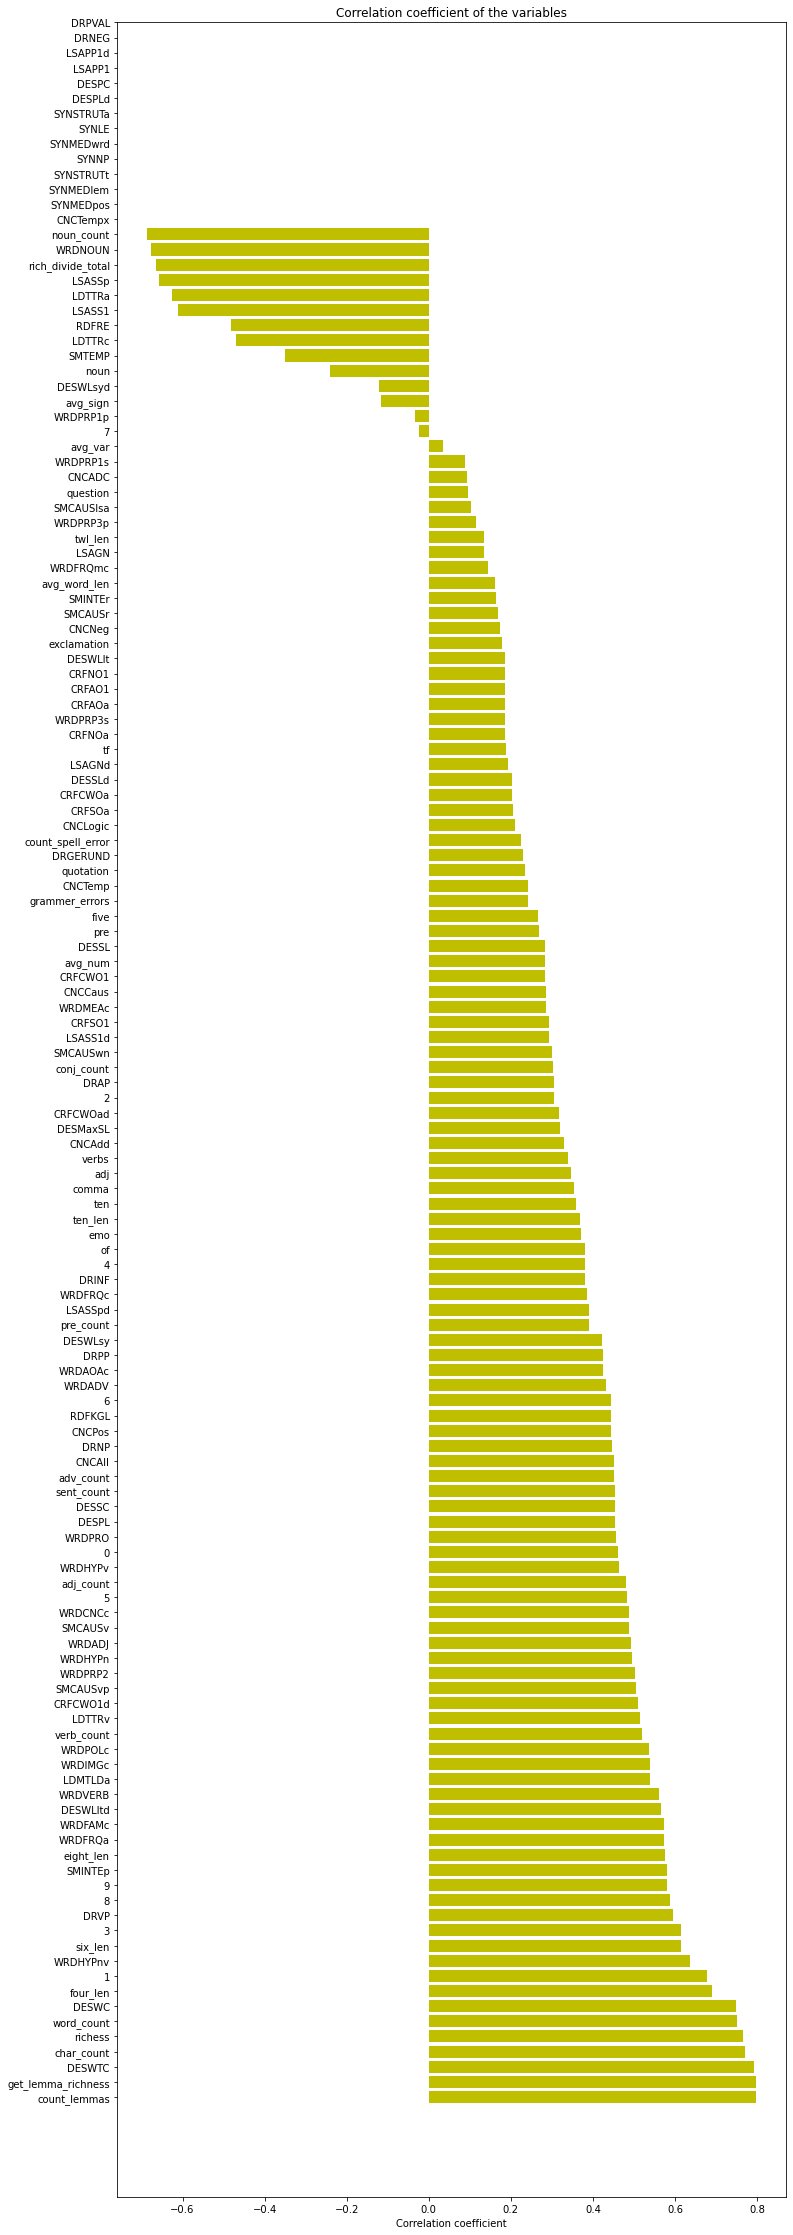

In [149]:
ind = np.arange(len(labels))
width = 0.5
fig,ax = plt.subplots(figsize = (12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
 
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Correlation coefficient of the variables')

## 数据标准化

In [151]:
# 数据标准化
from sklearn.preprocessing import StandardScaler
X_new = X_no_inf.values
y = score
scaler = StandardScaler() #实例化
scaler.fit(X_new) #fit，本质是生成均值和方差
scaler.mean_ #查看均值的属性mean_
scaler.var_ #查看方差的属性var_

array([1.45681296e+03, 2.29633002e+02, 1.59898524e-02, 4.94714555e-02,
       2.75077313e-02, 7.64828563e-04, 2.34889470e-03, 6.70344856e-04,
       7.20432408e-04, 1.82710147e-04, 2.98978719e-01, 2.34925964e+00,
       1.44844800e+01, 4.94805332e+01, 1.79890375e+02, 1.64300394e+01,
       2.65066002e+04, 4.37440758e+02, 4.37344284e+02, 2.41771639e+01,
       2.07785198e+01, 1.47509261e+04, 5.16411581e-01, 1.86159092e+00,
       2.44552532e+00, 8.23271794e+00, 1.05265722e+00, 1.05657607e+00,
       2.52148578e-01, 1.89818729e-01, 1.27911151e-01, 3.26163929e-01,
       4.14656246e+01, 1.31778838e+01, 2.22746093e-01, 1.01657523e+00,
       1.19191188e+00, 4.59061901e+01, 5.69216077e+01, 9.11049353e+00,
       7.83922002e+01, 6.05832908e+00, 7.88428159e+00, 5.85614516e+00,
       1.02140654e+00, 2.78720658e+01, 7.95829695e+01, 1.05849530e+02,
       5.22820670e+00, 4.87138502e+02, 3.25800485e+01, 1.36982047e+02,
       0.00000000e+00, 2.97654784e+03, 2.17798415e+02, 3.88944518e+00,
      

In [279]:
X_input = scaler.fit_transform(X_no_inf) #使用fit_transform(data)一步达成结果
#scaler.inverse_transform(x_std) #使用inverse_transform逆转标准化

# 把上面的X_input和word2vec函数连接在一起

In [246]:
df_X_input = pd.DataFrame(X_input)

In [253]:
# 这个把数据框连接在一起，然后直接返回拼接后的array
X_input2 = np.concatenate((df_X_input,word2vec_new),axis = 1)

In [254]:
X_input2.shape

(998, 237)

In [257]:
len(X_input2)

998

## 开始训练

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X_input, score, test_size = 0.2)

In [281]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
for i in range(len(y_test)):
    print("预测分数：{}".format(y_pred[i]),"实际分数：{}".format(y_test[i]))
# The coefficients 表示每一个特征所占的权重
print("测试集得分：\n",linear_regressor.score(X_test,y_test))
#print('LinearRegression Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print("LinearRegression Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# 平均绝对百分比误差（Mean Absolute Percentage Error）
#print('LinearRegression MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
#print("R2:%f"% r2_score(y_test, y_pred))
print('-' * 50)

预测分数：10.641700075383772 实际分数：13.0
预测分数：16.672950075383774 实际分数：18.5
预测分数：15.084571169133772 实际分数：16.0
预测分数：12.610450075383772 实际分数：6.5
预测分数：14.510840700383772 实际分数：16.5
预测分数：14.123145387883772 实际分数：15.5
预测分数：12.338965700383772 实际分数：12.5
预测分数：13.887793825383772 实际分数：15.5
预测分数：18.172950075383774 实际分数：20.0
预测分数：14.863868044133772 实际分数：17.0
预测分数：18.295996950383774 实际分数：20.5
预测分数：16.690528200383774 实际分数：18.5
预测分数：16.337012575383774 实际分数：19.5
预测分数：17.885840700383774 实际分数：19.5
预测分数：11.553077028508772 实际分数：15.0
预测分数：16.642676637883774 实际分数：17.5
预测分数：12.180762575383772 实际分数：9.0
预测分数：16.243262575383774 实际分数：20.5
预测分数：14.629981325383772 实际分数：17.0
预测分数：15.279883669133772 实际分数：19.5
预测分数：16.883887575383774 实际分数：20.0
预测分数：16.825293825383774 实际分数：14.0
预测分数：10.200293825383772 实际分数：4.5
预测分数：15.911231325383772 实际分数：19.0
预测分数：6.821387575383772 实际分数：7.5
预测分数：14.581153200383772 实际分数：14.0
预测分数：15.942481325383772 实际分数：13.5
预测分数：15.410254762883772 实际分数：15.0
预测分数：18.665137575383774 实际分数：14.0
预测分数：13.48837976288

In [282]:
from sklearn.metrics import classification_report
alpha = 200
ridge = Ridge(alpha=alpha)# 正则项的程度
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print("测试集得分：\n {0}".format(ridge.score(X_test,y_test)))
#print('Ridge Coefficients: \n', ridge.coef_)
print("Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print("R2:%f"% r2_score(y_test, y_pred))
#print('Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))

#print(classification_report(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)

# 最佳：
'''
V4:
测试集得分：
 0.6850381823446672
Ridge Mean squared error: 7.63
'''

测试集得分：
 0.6437570339589143
Ridge Mean squared error: 7.25
--------------------------------------------------


'\nV4:\n测试集得分：\n 0.6850381823446672\nRidge Mean squared error: 7.63\n'

In [283]:
# 分别使用树和随机森林
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)
y_train_new = y_train*10
y_test_new = y_test*10
y_test_new = y_test_new.astype("int")

#fit模型
clf = clf.fit(X_train,y_train_new.astype("int"))
rfc = rfc.fit(X_train,y_train_new.astype("int"))

#输出分数
score_c = clf.score(X_test,y_test_new.astype("int"))
score_r = rfc.score(X_test,y_test_new.astype("int"))

print("Single Tree:{}".format(score_c),"Random Forest:{}".format(score_r))

#-----------------------------------------#
# 查看测试结果
y_pred = rfc.predict(X_test)
for i in range(len(y_test_new)):
    print("预测分数：{}".format(y_pred[i]),"实际分数：{}".format(y_test_new[i]))

Single Tree:0.075 Random Forest:0.135
预测分数：140 实际分数：130
预测分数：190 实际分数：185
预测分数：175 实际分数：160
预测分数：120 实际分数：65
预测分数：150 实际分数：165
预测分数：150 实际分数：155
预测分数：150 实际分数：125
预测分数：120 实际分数：155
预测分数：195 实际分数：200
预测分数：170 实际分数：170
预测分数：205 实际分数：205
预测分数：175 实际分数：185
预测分数：160 实际分数：195
预测分数：185 实际分数：195
预测分数：120 实际分数：150
预测分数：170 实际分数：175
预测分数：170 实际分数：90
预测分数：165 实际分数：205
预测分数：170 实际分数：170
预测分数：170 实际分数：195
预测分数：185 实际分数：200
预测分数：175 实际分数：140
预测分数：135 实际分数：45
预测分数：130 实际分数：190
预测分数：110 实际分数：75
预测分数：140 实际分数：140
预测分数：175 实际分数：135
预测分数：175 实际分数：150
预测分数：170 实际分数：140
预测分数：170 实际分数：150
预测分数：175 实际分数：205
预测分数：195 实际分数：195
预测分数：125 实际分数：145
预测分数：160 实际分数：160
预测分数：175 实际分数：180
预测分数：170 实际分数：125
预测分数：170 实际分数：175
预测分数：150 实际分数：160
预测分数：175 实际分数：190
预测分数：170 实际分数：150
预测分数：195 实际分数：175
预测分数：0 实际分数：0
预测分数：150 实际分数：155
预测分数：165 实际分数：135
预测分数：190 实际分数：195
预测分数：190 实际分数：145
预测分数：175 实际分数：205
预测分数：150 实际分数：135
预测分数：160 实际分数：160
预测分数：155 实际分数：145
预测分数：160 实际分数：205
预测分数：185 实际分数：145
预测分数：175 实际分数：150
预测分数：135 实际分数：12

In [284]:
score_new = score*10
score_new = score_new.astype("int")

D:\Program\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
D:\Program\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


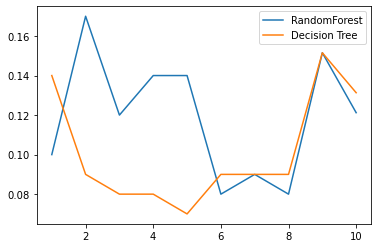

In [263]:
# 分类树绘制
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

rfc = RandomForestClassifier(n_estimators=25)
rfc_s = cross_val_score(rfc,X_input,score_new,cv=10)
clf = DecisionTreeClassifier()
clf_s = cross_val_score(clf,X_input,score_new,cv=10)

plt.plot(range(1,11),rfc_s,label = "RandomForest")
plt.plot(range(1,11),clf_s,label = "Decision Tree")
plt.legend()
plt.show()

In [286]:
%%time
# 随机森林回归测试，得到一个grid模型
rf = ensemble.RandomForestRegressor()
params = {'n_estimators': range(50,70,1), 'max_depth':[10, 50, 100], 'max_features':[2, 5, 10]}
grid = GridSearchCV(estimator=rf, param_grid=params)
grid.fit(X_train, y_train)

Wall time: 2min 54s


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 50, 100], 'max_features': [2, 5, 10],
                         'n_estimators': range(50, 70)})

In [287]:
# 数据探索
y_pred = grid.predict(X_test)

In [288]:
for i in range(len(y_test)):
    print("预测分数：{:.2f}".format(y_pred[i]),"实际分数：{}".format(y_test[i]))

预测分数：11.08 实际分数：13.0
预测分数：16.32 实际分数：18.5
预测分数：17.87 实际分数：16.0
预测分数：11.82 实际分数：6.5
预测分数：15.03 实际分数：16.5
预测分数：14.37 实际分数：15.5
预测分数：14.36 实际分数：12.5
预测分数：13.45 实际分数：15.5
预测分数：18.40 实际分数：20.0
预测分数：15.04 实际分数：17.0
预测分数：18.06 实际分数：20.5
预测分数：17.19 实际分数：18.5
预测分数：17.61 实际分数：19.5
预测分数：18.03 实际分数：19.5
预测分数：11.11 实际分数：15.0
预测分数：14.94 实际分数：17.5
预测分数：14.00 实际分数：9.0
预测分数：16.62 实际分数：20.5
预测分数：16.25 实际分数：17.0
预测分数：17.51 实际分数：19.5
预测分数：17.79 实际分数：20.0
预测分数：17.44 实际分数：14.0
预测分数：10.90 实际分数：4.5
预测分数：16.09 实际分数：19.0
预测分数：8.08 实际分数：7.5
预测分数：14.75 实际分数：14.0
预测分数：16.69 实际分数：13.5
预测分数：16.73 实际分数：15.0
预测分数：18.57 实际分数：14.0
预测分数：16.41 实际分数：15.0
预测分数：18.57 实际分数：20.5
预测分数：18.01 实际分数：19.5
预测分数：13.26 实际分数：14.5
预测分数：17.19 实际分数：16.0
预测分数：17.73 实际分数：18.0
预测分数：15.81 实际分数：12.5
预测分数：16.84 实际分数：17.5
预测分数：15.78 实际分数：16.0
预测分数：15.86 实际分数：19.0
预测分数：15.70 实际分数：15.0
预测分数：16.29 实际分数：17.5
预测分数：0.00 实际分数：0.0
预测分数：15.71 实际分数：15.5
预测分数：16.89 实际分数：13.5
预测分数：16.89 实际分数：19.5
预测分数：17.35 实际分数：14.5
预测分数：17.95 实际分数：20.5
预测分数：14.27 实际分数：13.5

In [289]:
print("测试集最佳得分：\n",grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)

y_pred

测试集最佳得分：
 0.7487018816342377
RandomForestRegressor(max_depth=100, max_features=10, n_estimators=54)
{'max_depth': 100, 'max_features': 10, 'n_estimators': 54}
Cohen's kappa score: 0.10
--------------------------------------------------


array([11.08333333, 16.32407407, 17.87037037, 11.82407407, 15.02777778,
       14.37037037, 14.36111111, 13.4537037 , 18.39814815, 15.03703704,
       18.05555556, 17.18518519, 17.61111111, 18.02777778, 11.11111111,
       14.94444444, 14.        , 16.62037037, 16.25      , 17.50925926,
       17.78703704, 17.43518519, 10.89814815, 16.09259259,  8.08333333,
       14.75      , 16.69444444, 16.73148148, 18.57407407, 16.40740741,
       18.57407407, 18.00925926, 13.25925926, 17.18518519, 17.73148148,
       15.80555556, 16.84259259, 15.77777778, 15.86111111, 15.7037037 ,
       16.28703704,  0.        , 15.71296296, 16.88888889, 16.88888889,
       17.35185185, 17.9537037 , 14.26851852, 15.87962963, 16.44444444,
       17.90740741, 17.11111111, 15.7037037 , 12.55555556, 12.61111111,
       17.31481481, 16.55555556, 15.02777778, 12.87962963, 14.71296296,
       12.25      , 15.71296296, 16.85185185, 17.78703704, 16.65740741,
       15.49074074, 16.53703704, 15.96296296, 16.38888889, 16.68